In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
from itertools import chain
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

In [4]:
import textgen

## Load data

In [5]:
comments_path = textgen.get_resource_path("toxicity-data-merged-comments-05251530.csv")
comments = pd.read_csv(comments_path, index_col=0)
posts_path = textgen.get_resource_path("toxicity-data-merged-posts-05251530.csv")
posts = pd.read_csv(posts_path, index_col=0)

In [6]:
def load_pretrained_wv(fpath):
    with open(fpath, "rb") as fin:
        (itos, stoi, vectors) = pickle.load(fin)
        src_vocab = textgen.Vocabulary(itos, stoi, vectors)
    return src_vocab
posts_vocab = load_pretrained_wv(textgen.get_resource_path("word_vectors.pkl"))

In [7]:
chunks = [x for x in chain.from_iterable([x.split("\\") for x in comments.CommentContent.tolist()])]

In [8]:
comments_vocab = textgen.Vocabulary()
comments_vocab.build_vocabulary(chunks)

In [9]:
posts_vocab, comments_vocab

(<Vocabulary: 27074 items, emb dim: (27074, 300)>, <Vocabulary: 1468 items>)

In [10]:
toxic_data = textgen.ToxicDataset(posts, comments, posts_vocab, comments_vocab)
toxic_data_path = textgen.get_data_path("toxic_data.pkl")
toxic_data.save(toxic_data_path)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\seantyh\AppData\Local\Temp\jieba.cache
Loading model cost 0.667 seconds.
Prefix dict has been built succesfully.


Cannot find gayo01
Cannot find gayo01
Cannot find gayo01


In [11]:
toxic_data = textgen.ToxicDataset.load(toxic_data_path)
toxic_data

<ToxicDataset: 240 samples>

## Batching Data

In [12]:
s0 = toxic_data[0][0]
s1 = toxic_data[50][0]
s1.shape

torch.Size([92])

In [13]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [14]:
from torch.utils.data import DataLoader
from functools import partial
collate_fn = partial(textgen.collate_fn, 
                     src_pad=posts_vocab.stoi["<PAD>"], 
                     tgt_pad=comments_vocab.stoi["<PAD>"])

In [15]:
xx, yy = next(iter(DataLoader(toxic_data, batch_size=2, collate_fn=collate_fn)))

In [16]:
model = textgen.ToxicCommentModel(posts_vocab, comments_vocab)
out = model(xx, yy)

In [17]:
out.shape

torch.Size([2, 5, 1468])

In [18]:
loss_fn = nn.CrossEntropyLoss()
adam = optim.Adam(model.parameters(), lr=0.1)
loss_vec = []

In [19]:
n_epoch = 20
for epoch_i in tqdm(range(n_epoch)):
    loss_epoch = []
    for src_batch, tgt_batch in DataLoader(toxic_data, batch_size=10, collate_fn=collate_fn):
        model = textgen.ToxicCommentModel(posts_vocab, comments_vocab)
        out = model(xx, yy)
        loss = loss_fn(out.view(*out.shape[1:], out.shape[0]), yy.view(yy.shape[1], -1))    
        loss_epoch.append(loss.item())

        adam.zero_grad()
        loss.backward()
        adam.step()
    loss_vec.append(np.mean(loss_epoch))
    

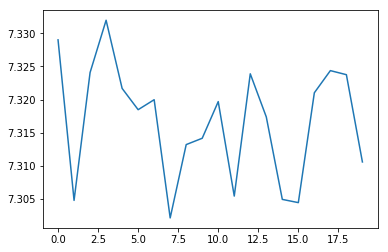

In [20]:
from matplotlib import pyplot as plt
plt.plot(loss_vec)

In [74]:
out = model(xx, yy)
print("ans: ", "/".join(comments_vocab.to_texts(yy.tolist()[1])))
print("gen: ", "/".join(comments_vocab.to_texts(out.argmax(2).numpy().tolist()[1])))

ans:  <SOS>/輸不起的/台女/噁心/<EOS>
gen:  /給予/2020總統大選入場卷！/受夠你四年執政，如果再四年給你執政/多P


['蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英',
 '蔡小英']

In [189]:
emb = model.embed(xx)

In [190]:
emb.shape

torch.Size([2, 3, 300])

In [191]:
model.conv1(emb.unsqueeze(1))

tensor([[[[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0510]],

         [[0.1459]],

         [[0.0000]],

         [[0.0000]],

         [[0.0405]],

         [[0.1414]],

         [[0.0000]],

         [[0.0057]],

         [[0.1552]],

         [[0.1536]],

         [[0.0000]],

         [[0.1265]],

         [[0.0000]],

         [[0.0000]],

         [[0.0740]],

         [[0.1071]],

         [[0.0000]]],


        [[[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0510]],

         [[0.1459]],

         [[0.0000]],

         [[0.0000]],

         [[0.0405]],

         [[0.1414]],

         [[0.0000]],

         [[0.0057]],

         [[0.1552]],

         [[0.1536]],

         [[0.0000]],

         [[0.1265]],

         [[0.0000]],

         [[0.0000]],

         [[0.0740]],

         [[0.1071]],

         [[0.0000]]]], grad_fn=<ReluBackward0>)